In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.io as io
import os
import json
from tqdm import tqdm

from PIL import Image
import torchvision.transforms as transforms

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    height = data.shape[-2] - y if height is None else height
    width = data.shape[-1] -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    return tr(data)

nb_frames = 10

class TrainVideoDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        with open(os.path.join(root_dir, "metadata.json"), 'r') as file :
            self.data= json.load(file)
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith('.mp4') and f in self.data.keys()]
        

    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        video, audio, info = io.read_video(video_path, pts_unit='sec')

        video=video.permute(0,3,1,2)
        l=video.shape[0]
        video=video[[i*(l//(nb_frames-1)) for i in range(nb_frames)]]

        images=[]
        for img in video :
            result=resize_data(img, 380, 380)/255
            images.append(result)
        
        X=torch.stack(images)

        label=self.data[self.video_files[idx]]['label']
        if label=='FAKE' :
            label=torch.tensor(float(1))
        else :
            label=torch.tensor(float(0))


    
dataset=TrainVideoDataset(os.path.expanduser("~/training"))

fake
torch.Size([152, 3, 1920, 1080])


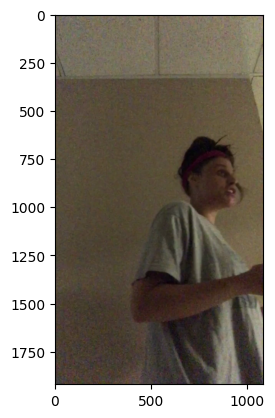

In [6]:
import matplotlib.pyplot as plt

def display_image(img) :
    img = img.permute(1,2,0)
    plt.imshow(img)

video, label = dataset[0]
img = video[0]

display_image(img)
print(label)
print(video.shape)

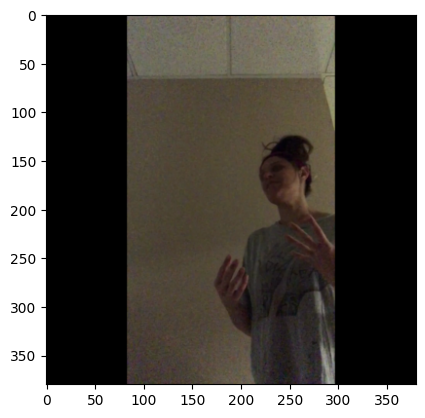

In [19]:


video, label = dataset[30]
img=video[0]


img=resize_data(img, 380, 380)
display_image(img)


Modèle

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense=nn.Linear(nb_frames*3*380*380,1)
        self.flat=nn.Flatten()
        
    def forward(self, x):
        y=self.flat(x)
        y=self.dense(y)
        return y

Boucle d'entraînement

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
model = DeepfakeDetector().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

max_iters=4
nb_epochs=5

loader=DataLoader(dataset, batch_size=2, shuffle=True)

for epoch in range(nb_epochs) :
    pbar = tqdm(loader, total=max_iters, desc="Epoch {}".format(epoch), ncols=0)
    for sample in pbar :
        optimizer.zero_grad()

        X, label=sample
        
        X = X.to(device)
        label = label.to(device)
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        print(f"Loss {loss.item():.4f}")
    pbar.close()

IndentationError: expected an indented block after 'for' statement on line 20 (3331820801.py, line 22)

Boucle de test

In [ ]:
#npy, np.save


class TestVideoDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith('.mp4')]
        with open(root_dir+"\metadata.json", 'r') as file :
            self.data= json.load(file)

    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        video, audio, info = io.read_video(video_path, pts_unit='sec')

        return video.permute(0,3,1,2), self.data[self.video_files[idx]]['label']
    
